In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class UKF:
    def __init__(self, f, h, P, Q, R, alpha=1e-3, beta=2, kappa=0):
        '''
        f: Prediction function
        h: Measurement function
        P: Predicted estimate covariance
        Q: The covariance of the process noise
        R: The covariance of the observation noise
        K: Kalman gain
        '''       
        self.f = f
        self.h = h
        self.P = P        
        self.Q = Q
        self.R = R
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.K = None
        
    def step(self, x, z):
        # Get Sigma points and Weights
        sigma_points, wm, wc = self.get_unscented_parameter(x, self.P, alpha=self.alpha, beta=self.beta, kappa=self.kappa)
        
        # Prediction
        x, self.P = self.UT(self.f, sigma_points, wm, wc)
        self.P = self.P + self.Q
        
        # Measurement
        z_hat, Pz = self.UT(self.h, sigma_points, wm, wc)
        Pz = Pz + self.R
        
        # Calculation Kalman Gain
        Pxz = self.get_Pxz(self.f, x, self.h, z_hat, sigma_points, wc)        
        self.K = np.dot(Pxz, np.linalg.pinv(Pz))
            
        # Estimation
        x = x + np.dot(self.K, z-z_hat)
        self.P = self.P - np.dot(self.K, np.dot(Pz, self.K.T))
        return x

    def get_unscented_parameter(self, x, P, alpha=1e-3, beta=2, kappa=0):
        n = np.size(x)
        l = np.square(alpha) * (n + kappa) - n
        u = np.linalg.cholesky((n+l)*P)

        # Sigma Point
        sigma_points = np.zeros((2*n+1, n, 1))
        sigma_points[0] = x
        for i in range(n):
            sigma_points[i+1] = x + u[i].reshape(-1, 1)
            sigma_points[i+n+1] = x - u[i].reshape(-1, 1)

        # Weight
        wm = np.zeros(2*n+1)
        wc = np.zeros(2*n+1)    
        wm[0] = l/(n+l)
        wc[0] = l/(n+l) + (1-np.square(alpha)+beta)    
        for i in range(1, 2*n+1):
            wm[i] = 1/(2*(n+l))
            wc[i] = 1/(2*(n+l))
        return sigma_points, wm, wc
    
    def UT(self, func, sigma_points, wm, wc):
        mean = np.sum([w*func(s) for s, w in zip(sigma_points, wm)], axis=0)
        cov  = np.sum([w*np.dot(func(s)-mean, (func(s)-mean).T) for s, w in zip(sigma_points, wc)], axis=0)
        return mean, cov
    
    def get_Pxz(self, f, x, h, z, sigma_points, wc):
        cov = np.sum([w*np.dot(f(s)-x, (h(s)-z).T) for s, w in zip(sigma_points, wc)], axis=0)
        return cov

### Data

In [3]:
# Set Random Seed
np.random.seed(42)

# Generate Data
position = 0
velocity = 100
altitude = 1000
dt = 0.05

num = 400
mea_dis = []
mea_pos = []
mea_vel = []
mea_alt = []
for i in range(num):
    v = velocity + 5 * np.random.randn()
    a = altitude + 10 * np.random.randn()
    p = position + velocity * dt
    d = np.sqrt(np.square(a) + np.square(p)) + p * 0.05 * np.random.randn()
    mea_dis.append(d)
    mea_pos.append(p)
    mea_vel.append(v)
    mea_alt.append(a)
    position = p

### Run

In [4]:
# Set Parameters
x = np.matrix([[0], 
               [90],
               [1100]])
P = np.matrix([[100, 0, 0], 
               [0, 100, 0],
               [0, 0, 100]])
Q = np.matrix([[0.01, 0, 0], 
               [0, 0.01, 0],
               [0, 0, 0.01]])
R = np.matrix([[10]])

def predict(x, dt=0.05):
    A = np.eye(3) + dt*np.matrix([[0, 1, 0],
                                  [0, 0, 0], 
                                  [0, 0, 0]])     
    return np.dot(A, x)

def measure(x):
    return np.sqrt(x[0, 0]**2+x[2, 0]**2)

# UKF
ukf = UKF(predict, measure, P, Q, R)
est_pos = []
est_vel = []
est_alt = []
Ps = []
Ks = []
for z in mea_dis:
    z = np.matrix([z])
    x = ukf.step(x, z)
    est_pos.append(x[0, 0])
    est_vel.append(x[1, 0])
    est_alt.append(x[2, 0])
est_dis = np.sqrt(np.square(est_pos) + np.square(est_alt))

### Graph

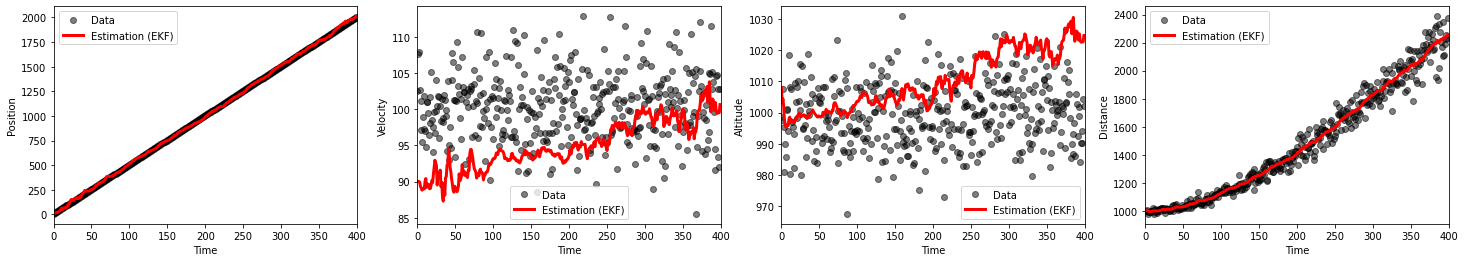

In [5]:
plt.figure(figsize=(25, 4))

plt.subplot(1, 4, 1)
plt.plot(mea_pos, 'o', alpha=0.5, color='k', label='Data')
plt.plot(est_pos, lw=3, color='r', label='Estimation (EKF)')
plt.legend()
plt.xlim(0, num)
plt.xlabel('Time')
plt.ylabel('Position')

plt.subplot(1, 4, 2)
plt.plot(mea_vel, 'o', alpha=0.5, color='k', label='Data')
plt.plot(est_vel, lw=3, color='r', label='Estimation (EKF)')
plt.legend()
plt.xlim(0, num)
plt.xlabel('Time')
plt.ylabel('Velocity')

plt.subplot(1, 4, 3)
plt.plot(mea_alt, 'o', alpha=0.5, color='k', label='Data')
plt.plot(est_alt, lw=3, color='r', label='Estimation (EKF)')
plt.legend()
plt.xlim(0, num)
plt.xlabel('Time')
plt.ylabel('Altitude')

plt.subplot(1, 4, 4)
plt.plot(mea_dis, 'o', alpha=0.5, color='k', label='Data')
plt.plot(est_dis, lw=3, color='r', label='Estimation (EKF)')
plt.legend()
plt.xlim(0, num)
plt.xlabel('Time')
plt.ylabel('Distance')

plt.show()